# Forecasting U.S. Housing Bubble using Machine Learning techniques

## Author

> - New York University Master of Arts in Economics <br>  
>
> - Junhoe Choi 
>
> - May 20, 2022

## 1. Introduction

&ensp; The rapid growth of residential property prices over the recent years in the United States has raised concerns regarding the existence of a bubble in the housing market. This circumstance should be deeply concerning as real estate volatility on large scale and intensity can have long-lasting and destructive effects on an economy. Our history, especially the Global Financial Crisis, had shown the catastrophic aftershocks of the burst of real estate bubbles. Therefore, predicting the future bubble will help to prevent such bleak outcomes, including a long-term economic recession. <br>

&ensp; For this project, my target variable is housing bubble periods. Unlike recession, there is no data for housing bubble periods. Therefore, I apply the backward supremum augmented Dickey-Fuller (BSADF) statistic which is proposed by Phillips, Shi, and Yu (2015) to detect the housing bubble. For input variables, I use house price index, rent index, inflation, M2 stock, Real GDP growth, Producer Price Index, Unemployment rate, and interest rates. With this dataset, I build two classifier models to predict bubbles in the U.S. Housing Market. That is simple RNN model and LSTM model.


In [2]:
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web


import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from sklearn.preprocessing import StandardScaler

from keras.layers import LSTM, Dropout, Dense
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

%matplotlib inline


## 2. Data Description

### Target Variables

&ensp;For this project, the target variable is the housing bubble. It is a binary variable that can be expressed as if the bubble exists, the target variable is one and if the bubble does not exist, y is zero. I measured the existence of the bubble using housing prices and rent. I plan to make two bubble periods. One is the housing bubble period captured by the house price index and the other is the housing bubble period captured by the rent index. I will use the latter one as the proxy of the housing bubble detection if the former one does not produce convincing results. My baseline period is January 1976 to October 2021.  

&ensp;To measure the housing price, I use the house price index constructed by [Federal Housing Finance Agency](https://fred.stlouisfed.org/series/USSTHPI). The house price index is proxied by the repeat-transaction house price indices. It is constructed with prices from sales transactions of mortgage data obtained from the Enterprises and prices from appraisal data obtained from the Enterprises. The data is in quarterly frequency based on 1980 Q1=100.  

&ensp;To measure the rent, I use the rent index constructed by [Bureau of Labor Statistics](https://fred.stlouisfed.org/series/CUUR0000SEHA). The rent index is proxied by the rent of the primary residence, which is a component of the consumer price index (all urban consumers). The data is also in quarterly frequency based on 1982-84:100.  

&ensp;To capture the housing bubble period, I apply the backward supremum augmented Dickey-Fuller (BSADF) statistic which is proposed by Phillips, Shi, and Yu (2015). I use [psymonitor package](https://cran.r-project.org/web/packages/psymonitor/psymonitor.pdf) in R to follow their work. ”psymonitor” provides an accessible implementation of real-time monitoring strategy with a new bootstrap method to reduce the potential impact of heteroskedasticity to effect family-wise size control in recursive testing algorithms. This methodology has been shown effective for bubble and crisis detection. For coding, I used BIC to select the number of lags and set the maximum number of lags to 6. I iterate 10000 times for the bootstrap. The results are obtained by extrapolating from this [blog](https://itamarcaspi.github.io/psymonitor/index.html).


In [3]:
def pct_change_on_last_year_quarterly(df):
    "compute pct_change on previous year, assuming quartly"
    return (df - df.shift(4))/df.shift(4)

In [4]:
start = "1975-01"
end = datetime.date.today()

hpi = (
        web.DataReader(["USSTHPI"], "fred", start, end) #Index 1980=100, 
        .resample("QS")
        .mean()
        
        .dropna()
        
    )


rent = (
    web.DataReader(["CUUR0000SEHA"], "fred", start, end) #Index 1982-1984=100
        .resample("QS")
        .mean()
        
        .dropna()
)

housingdata=hpi.join(rent)\
                    .dropna()\
                    .rename(columns=dict(USSTHPI="hpi",CUUR0000SEHA="rent"))

housingdata.head()            

,hpi,rent
DATE,,
1975-01-01,60.01,57.033333
1975-04-01,60.96,57.600000
1975-07-01,61.15,58.266667
1975-10-01,62.24,59.100000
1976-01-01,62.88,59.966667


In [5]:
housingdata.to_csv('/Users/choejunhoe/Desktop/Housingbubbleproject/MLProject/code_anddata/nominal_hpi.csv')

### Detecting bubble

&ensp; I use R studio to detect bubble. This will be my target variable. <br>

Below is the result from the R code that I use. I apply the psymonitor” package using house price index. (Details are in the R code.)

In [8]:
bubble = pd.read_csv('/Users/choejunhoe/Desktop/Housingbubbleproject/MLProject/code_anddata/hpi_bubble.csv')
bubble = bubble.iloc[: , 1:]
bubble.head()

,DATE,hpi,rent,bubble
0,1/1/76,62.88,59.966667,0
1,4/1/76,65.45,60.733333,0
2,7/1/76,66.51,61.533333,0
3,10/1/76,67.25,62.333333,0
4,1/1/77,69.48,63.433333,0


## Input Variables

&ensp; My input dataset is an adapted version of the one used in "Stock Market Crisis Forecasting Using Neural Networks with Input Factor Selection" by Felix Fuchs, Markus Wahl, Rudi Zagst, and Xinyi Zheng(2022). I use nine input variables. That is percentage change in house price and rent, housing permits, inflation, M2 stock, Real GDP growth, Producer Price Index, Unemployment, and Interest rate. The frequencies of all input variables are quarterly data. The measurement is as follows. 

&ensp; For percentage change in house price and rent, I use the same dataset as I used to detect the housing bubble. I only convert the nominal value into quarterly percentage change.  

&ensp; To measure housing permits, I use data set constructed by [U.S. Census Bureau and U.S. Department of Housing and Urban Development](https://fred.stlouisfed.org/series/PERMIT). The housing permits are proxied by new privately-owned housing units authorized in permit-issuing places(in thousands).  

&ensp; To measure inflation, I use the consumer price index for all urban consumers data in quarterly frequency from [FRED](https://fred.stlouisfed.org/series/CPIAUCSL). This data, which is constructed by the U.S. Bureau of Labor Statistics, is a price index of a basket of goods and services paid by urban consumers. I convert the CPI into the inflation rate by using the percentage change from one year ago.  

&ensp; To measure the change in M2 stock, I use M2(M2NS) from [FRED](https://fred.stlouisfed.org/series/M2NS) which is constructed by the Board of Governors of the Federal Reserve System (US). I am using the quarterly percentage change of the M2 stock.  

&ensp; To measure the real GDP growth rate, I use Real Gross Domestic Product from [FRED](https://fred.stlouisfed.org/series/GDPC1) which is constructed by the U.S. Bureau of Economic Analysis. I am also using a quarterly percentage change of the real GDP.  

&ensp; To measure the change in the producer price index, I use Producer Price Index by all commodities from [FRED](https://fred.stlouisfed.org/series/PPIACO) which is constructed by the U.S. Bureau of Labor Statistics. I am also the using quarterly percentage change of the PPI.

&ensp; The unemployment rate is measured by the Unemployment Rate from [FRED](https://fred.stlouisfed.org/series/UNRATE) which is constructed by the U.S. Bureau of Labor Statistics. The interest rate is measured by the Federal Funds Effective Rate from [FRED](https://fred.stlouisfed.org/series/DFF) which is constructed by the Board of Governors of the Federal Reserve System (US).

The code is as follows.


In [9]:
# My list contains permits, unemployment rate, M2 Stock, Real GDP, CPI for all urban consumers and Federal Fund Rate and Producer Price Index by Commodity. 

permit = (
        web.DataReader(["PERMIT"], "fred", start, end)
        .resample("QS")
        .mean()
        .dropna()
    )

M2_GDP_PPI = (
    # relative quarterly change of M2 Stock, Real GDP and PPI.
        web.DataReader(["M2NS","GDPC1","PPIACO"], "fred", start, end) 
        .resample("QS")
        .mean()
        .pct_change()
        .dropna()
    )
Inflation= (# Inflation calculated with CPI
        web.DataReader(["CPIAUCSL"], "fred", start, end) 
        .resample("QS")
        .mean()
        .pipe(pct_change_on_last_year_quarterly)
        .dropna()

)

UNEMP_FFR = (
    # Unemployment rate and Federal Fund Rate.
        web.DataReader(["UNRATE","DFF"], "fred", start, end) 
        .resample("QS")
        .mean()
        .dropna()
    )



indicator=housingdata   .join(permit)\
                        .join(M2_GDP_PPI)\
                        .join(Inflation)\
                        .join(UNEMP_FFR)\
                        .rename(columns=dict(UNRATE="unempolyment",M2NS="M2",GDPC1="GDP", CPIAUCSL= "Inflation", DFF="Federal Fund Rate",PPIACO="PPI",PERMIT="permits"))\
                        .dropna()

indicator.head()

,hpi,rent,permits,M2,GDP,PPI,Inflation,unempolyment,Federal Fund Rate
DATE,,,,,,,,,
1976-01-01,62.88,59.966667,1183.000000,0.030482,0.022488,0.004469,0.063412,7.733333,4.826484
1976-04-01,65.45,60.733333,1171.333333,0.034660,0.007337,0.015573,0.060150,7.566667,5.195385
1976-07-01,66.51,61.533333,1345.000000,0.024643,0.005487,0.012048,0.055897,7.733333,5.283478
1976-10-01,67.25,62.333333,1489.000000,0.035271,0.007249,0.008658,0.051870,7.766667,4.874239
1977-01-01,69.48,63.433333,1562.000000,0.031960,0.011815,0.021459,0.059034,7.500000,4.660667


In [15]:
indicator.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hpi,184.0,244.049511,117.909963,62.880000,145.932500,216.410000,342.085000,557.730000
rent,184.0,187.433480,80.792564,59.966667,123.350000,175.033333,249.105667,354.449667
permits,184.0,1377.666667,380.290895,538.666667,1114.750000,1398.000000,1670.583333,2228.333333
M2,184.0,0.016817,0.012384,-0.005693,0.010134,0.015568,0.021527,0.131024
GDP,184.0,0.006798,0.011474,-0.089373,0.003601,0.007293,0.010707,0.075475
PPI,184.0,0.007823,0.019519,-0.111906,-0.000377,0.007374,0.016982,0.065990
Inflation,184.0,0.036111,0.027469,-0.016070,0.018956,0.029115,0.043074,0.144258
unempolyment,184.0,6.262862,1.697826,3.600000,5.000000,5.883333,7.341667,12.966667
Federal Fund Rate,184.0,4.716309,4.030789,0.058791,1.119484,4.822481,6.779558,17.786923


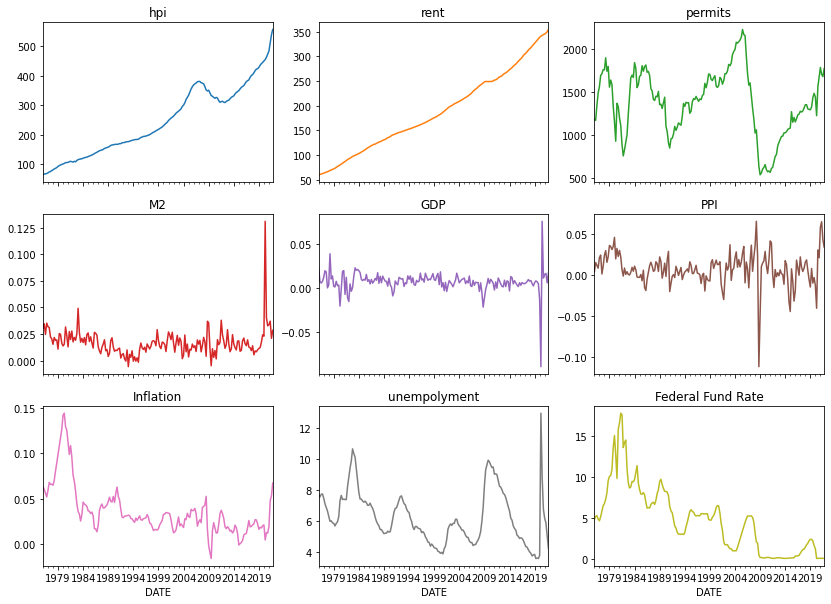

In [10]:
axs = indicator.plot(subplots=True, figsize=(14, 10), layout=(3, 3), legend=False)

for i, ax in enumerate(axs.flatten()):
    
    ax.set_title(list(indicator)[i])



Above plots show general overview of the dataset.

For this project, I use the percentage change in house price index and rent index as my inputs. 

In [16]:
hpi_pct_change = (
        web.DataReader(["USSTHPI"], "fred", start, end) #Index 1980=100, 
        .resample("QS")
        .mean()
        .pct_change()
        .dropna()
        
        
    )

rent_pct_change = (
    web.DataReader(["CUUR0000SEHA"], "fred", start, end) #Index 1982-1984=100
        .resample("QS")
        .mean()
        .pct_change()
        .dropna()
        
)

indicator["hpi"]= hpi_pct_change
indicator["rent"]= rent_pct_change

indicator.head()


,hpi,rent,permits,M2,GDP,PPI,Inflation,unempolyment,Federal Fund Rate
DATE,,,,,,,,,
1976-01-01,0.010283,0.014664,1183.000000,0.030482,0.022488,0.004469,0.063412,7.733333,4.826484
1976-04-01,0.040872,0.012785,1171.333333,0.034660,0.007337,0.015573,0.060150,7.566667,5.195385
1976-07-01,0.016196,0.013172,1345.000000,0.024643,0.005487,0.012048,0.055897,7.733333,5.283478
1976-10-01,0.011126,0.013001,1489.000000,0.035271,0.007249,0.008658,0.051870,7.766667,4.874239
1977-01-01,0.033160,0.017647,1562.000000,0.031960,0.011815,0.021459,0.059034,7.500000,4.660667


I add a new column for the housing bubble dummy variable captured by the house price index.

In [17]:
indicator['bubble']=np.array(bubble["bubble"])
indicator.head()

,hpi,rent,permits,M2,GDP,PPI,Inflation,unempolyment,Federal Fund Rate,bubble
DATE,,,,,,,,,,
1976-01-01,0.010283,0.014664,1183.000000,0.030482,0.022488,0.004469,0.063412,7.733333,4.826484,0
1976-04-01,0.040872,0.012785,1171.333333,0.034660,0.007337,0.015573,0.060150,7.566667,5.195385,0
1976-07-01,0.016196,0.013172,1345.000000,0.024643,0.005487,0.012048,0.055897,7.733333,5.283478,0
1976-10-01,0.011126,0.013001,1489.000000,0.035271,0.007249,0.008658,0.051870,7.766667,4.874239,0
1977-01-01,0.033160,0.017647,1562.000000,0.031960,0.011815,0.021459,0.059034,7.500000,4.660667,0


In [18]:
indicator.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hpi,184.0,0.012079,0.013517,-0.031513,0.007471,0.012206,0.017638,0.055806
rent,184.0,0.009794,0.004794,-0.000420,0.006749,0.008732,0.012311,0.026234
permits,184.0,1377.666667,380.290895,538.666667,1114.750000,1398.000000,1670.583333,2228.333333
M2,184.0,0.016817,0.012384,-0.005693,0.010134,0.015568,0.021527,0.131024
GDP,184.0,0.006798,0.011474,-0.089373,0.003601,0.007293,0.010707,0.075475
PPI,184.0,0.007823,0.019519,-0.111906,-0.000377,0.007374,0.016982,0.065990
Inflation,184.0,0.036111,0.027469,-0.016070,0.018956,0.029115,0.043074,0.144258
unempolyment,184.0,6.262862,1.697826,3.600000,5.000000,5.883333,7.341667,12.966667
Federal Fund Rate,184.0,4.716309,4.030789,0.058791,1.119484,4.822481,6.779558,17.786923
bubble,184.0,0.217391,0.413596,0.000000,0.000000,0.000000,0.000000,1.000000


The above summary statistics show that majority of the bubble dummy values are false values.

Now, I will draw graphs for inputs that include the housing bubble period as shaded regions.

In [19]:
bubble_dummy= indicator.iloc[:,-1:].squeeze()
bubble_dummy

DATE
1976-01-01    0
1976-04-01    0
1976-07-01    0
1976-10-01    0
1977-01-01    0
             ..
2020-10-01    0
2021-01-01    0
2021-04-01    0
2021-07-01    0
2021-10-01    0
Freq: QS-JAN, Name: bubble, Length: 184, dtype: int64

In [20]:
def get_bubble_data(): 
 # extract start and end date for each bubble period
    start_dates = bubble_dummy.loc[bubble_dummy.diff() > 0].index.tolist()
    if bubble_dummy.iloc[0] > 0:
        start_dates = [bubble_dummy.index[0]] + start_dates

    end_dates = bubble_dummy.loc[bubble_dummy.diff() < 0].index.tolist()

    if (len(start_dates) != len(end_dates)) and (len(start_dates) != len(end_dates) + 1):
        raise ValueError("Need to have same number of start/end dates!")

    return start_dates, end_dates

start_dates, end_dates = get_bubble_data()

print(start_dates)
print(end_dates)


[Timestamp('1997-01-01 00:00:00'), Timestamp('1997-07-01 00:00:00'), Timestamp('2017-10-01 00:00:00')]
[Timestamp('1997-04-01 00:00:00'), Timestamp('2006-04-01 00:00:00'), Timestamp('2018-10-01 00:00:00')]


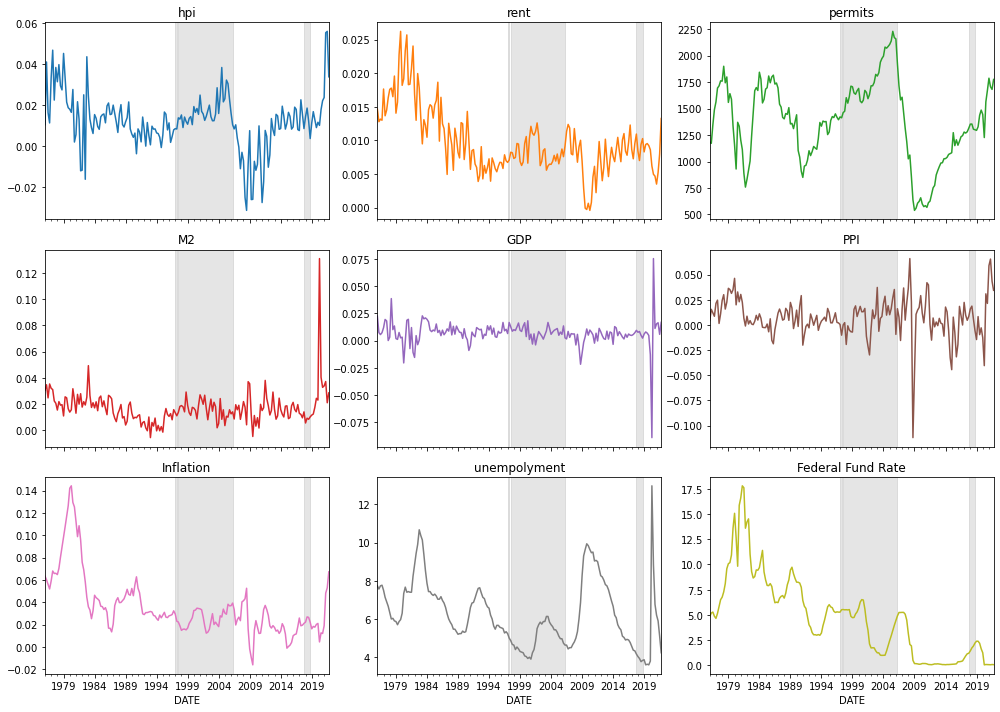

In [21]:
indicator_plot= indicator.iloc[: , :-1]

def add_bubble_bands(ax):
    for s, e in zip(start_dates, end_dates):
        ax.axvspan(s, e, color="grey", alpha=0.2)

axs = indicator_plot.plot(subplots=True, figsize=(14, 10), layout=(3, 3), legend=False)

for i, ax in enumerate(axs.flatten()):
    add_bubble_bands(ax)
    ax.set_title(list(indicator_plot)[i])

fig = axs[0, 0].get_figure()
fig.tight_layout();


The shaded areas above are the periods when the bubble was detected. 

According to the dataset, the first bubble episode is from January 1997 to April 1997 (1997 Q1), second bubble episode is from July 1997 to April 2006 and last bubble episode is from October 2017 to October 2018. The second bubble episode is before the Global Financial Crisis which mortgage bubble triggered the crisis.

---

### Data Preprocessing

Since we are using a simple RNN and LSTM model, first, we should normalize our input data and, second, we also should convert the time series dataset to a supervised learning problem. For this project, I am conducting multivariate and multi-step forecasting.

In [23]:
#normalizing inputs
bubble_features= indicator.loc[:,'hpi':"Federal Fund Rate"]
scaler = StandardScaler()
scaler = scaler.fit(bubble_features)
bubble_scaled = scaler.transform(bubble_features)

In [24]:
bubble_features_scaled = pd.DataFrame(bubble_scaled, columns=['hpi','rent','permits','M2','GDP','PPI','Inf','unemp','FFR'])
bubble_features_scaled['bubble']=bubble['bubble']

### Multivariate and Multi-step forecasting

I frame the supervised learning problem as predicting the bubble next three month, six months, and nine months given the input variables at the window width of 4. This implies the model uses four time steps for each input time series as input and predicts the next three time steps of the output sequence beyond the dataset.  

The code is as follows.

In [25]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequences)):
      # find the end of this pattern
      end_ix = i + n_steps_in
      out_end_ix = end_ix + n_steps_out-1
    # check if we are beyond the dataset
      if out_end_ix > len(sequences):
         break
    # gather input and output parts of the pattern
      seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
      X.append(seq_x)
      y.append(seq_y)
  return np.array(X), np.array(y)


In [26]:
X , y = split_sequences(np.array(bubble_features_scaled),4,3)

In [27]:
for i in range(len(X)):
  print(X[i], y[i])


[[-0.13324633  1.01873328 -0.51328554  1.10643844  1.37118826 -0.17227842
   0.99655337  0.86845347  0.02740777]
 [ 2.13583934  0.62556809 -0.54404752  1.44476127  0.04713772  0.39812949
   0.87750925  0.7700209   0.11917831]
 [ 0.30536735  0.70661752 -0.08613353  0.63364961 -0.11453414  0.21706208
   0.72223881  0.86845347  0.14109313]
 [-0.07068475  0.670794    0.29355714  1.49424424  0.03940382  0.04290321
   0.57523595  0.88813998  0.0392878 ]] [0. 0. 0.]
[[ 2.13583934  0.62556809 -0.54404752  1.44476127  0.04713772  0.39812949
   0.87750925  0.7700209   0.11917831]
 [ 0.30536735  0.70661752 -0.08613353  0.63364961 -0.11453414  0.21706208
   0.72223881  0.86845347  0.14109313]
 [-0.07068475  0.670794    0.29355714  1.49424424  0.03940382  0.04290321
   0.57523595  0.88813998  0.0392878 ]
 [ 1.5637856   1.64265169  0.48603922  1.22616373  0.43846712  0.70052113
   0.83675716  0.73064787 -0.01384205]] [0. 0. 0.]
[[ 0.30536735  0.70661752 -0.08613353  0.63364961 -0.11453414  0.2170620

I use the first 70% of the dataset as the train dataset and the remaining as the validation dataset.

In [28]:
training_size = int(len(X) * 0.7)
X_train, y_train = X[:training_size], y[:training_size]
X_test, y_test = X[training_size:], y[training_size:]


## 3. Model Description

I will a use simple RNN model and LSTM model to predict next three time steps. I tune hyperparameters and try different optimizer, number of layers, number of neurons per layer and dropout vs no dropout.

### Simple RNN model
For simple RNN model, I used relu activation function with 0.25 dropout. I combine the RNN model with additional hidden dense layer to obtain higher accuracy. I use RMSProp optimizer, binary crossestropy loss function, and binary accuracy metrics. Moreover, I used 10 neurons for RNN layer, 5 neurons for hidden dense layer and sigmoid activation function for the last layer. I use 200 epochs to check underfitting and overfitting. 

In [20]:
model = keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(10, activation="relu",input_shape=(X.shape[1],X.shape[2]) ,return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(3,activation="relu"))
model.add(Dense(y.shape[1],activation="sigmoid"))

model.compile(optimizer="RMSProp",loss="binary_crossentropy", metrics=[keras.metrics.binary_accuracy]) 

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 10)                200       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
 dense_3 (Dense)             (None, 3)                 12        
                                                                 
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(
    X_train, y_train,
    epochs=200,
    validation_data=(X_test,y_test)
)

train_loss_keras, train_acc_keras = model.evaluate(X_train, y_train)
test_loss_keras, test_acc_keras = model.evaluate(X_test, y_test)




Epoch 1/200
4/4 [==============================] - 1s 74ms/step - loss: 0.6540 - binary_accuracy: 0.5813 - val_loss: 0.6489 - val_binary_accuracy: 0.7160
Epoch 2/200
4/4 [==============================] - 0s 8ms/step - loss: 0.6244 - binary_accuracy: 0.6160 - val_loss: 0.6448 - val_binary_accuracy: 0.7099
Epoch 3/200
4/4 [==============================] - 0s 11ms/step - loss: 0.6261 - binary_accuracy: 0.6107 - val_loss: 0.6410 - val_binary_accuracy: 0.7160
Epoch 4/200
4/4 [==============================] - 0s 13ms/step - loss: 0.6220 - binary_accuracy: 0.5920 - val_loss: 0.6372 - val_binary_accuracy: 0.7222
Epoch 5/200
4/4 [==============================] - 0s 14ms/step - loss: 0.6017 - binary_accuracy: 0.6320 - val_loss: 0.6333 - val_binary_accuracy: 0.7222
Epoch 6/200
4/4 [==============================] - 0s 13ms/step - loss: 0.6037 - binary_accuracy: 0.6320 - val_loss: 0.6299 - val_binary_accuracy: 0.7284
Epoch 7/200
4/4 [==============================] - 0s 14ms/step - loss: 0.592

In [22]:
print('Test accuracy using keras:', test_acc_keras)
print('Train accuracy using keras:', train_acc_keras)

print('Test loss using keras:', test_loss_keras)
print('Train loss using keras:', train_loss_keras)

Test accuracy using keras: 0.8086419701576233
Train accuracy using keras: 0.9813333749771118
Test loss using keras: 0.25849148631095886
Train loss using keras: 0.1518109291791916


The result above shows that it has 80% test accuracy and 25% test loss. Now, I check overfitting by drawing history accuracy and loss values. It is shown below.

<AxesSubplot:>

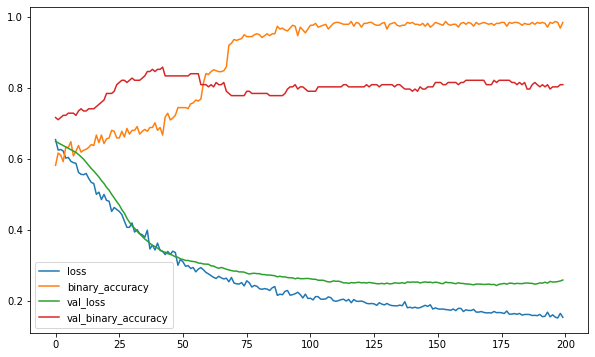

In [23]:
pd.DataFrame(history.history).plot(figsize=(10,6))

In [46]:
def make_binary_acc_loss_plot(history):

    epoch = history.epoch

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))

    # Accuracy
    ax[0].plot(epoch, history.history["binary_accuracy"], linestyle="-.", label="Training")
    ax[0].plot(epoch, history.history["val_binary_accuracy"], linestyle="-", label="Validation")
    ax[0].legend()
    ax[0].set_title("Model accuracy")

    # Loss
    ax[1].plot(epoch, history.history["loss"], linestyle="-.")
    ax[1].plot(epoch, history.history["val_loss"])
    ax[1].set_title("Loss")

    fig.tight_layout()

    return fig

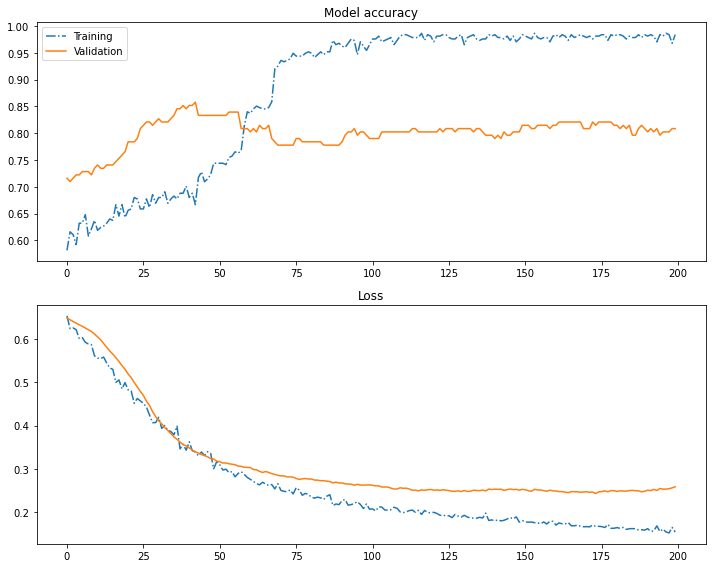

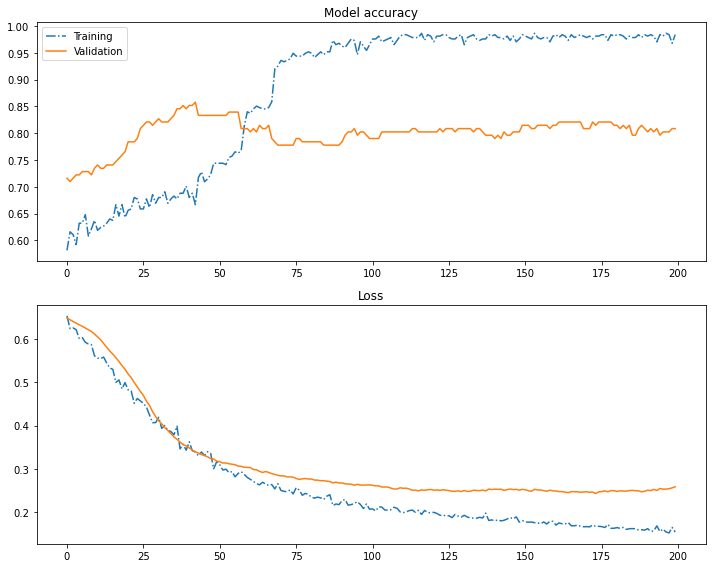

In [25]:
make_binary_acc_loss_plot(history)

Above graphs show that there is a slight overfitting after 125 epochs. However, since it has high accuracy and low loss, the model looks good enough.

According to above model, it demonstrates prediction as follows.

In [236]:
# demonstrate prediction
X_input_hpi=X[-1]
X_input_hpi= X_input_hpi.reshape((1, X.shape[1], X.shape[2]))
yhat_rnn = model.predict(X_input_hpi))
print(yhat_rnn)

[[0.6311022  0.6223203  0.64255494]]


The above results imply that, according to the simple RNN model, the probability of an existing bubble next three months is 63.11%, the next six months is 62.24% and the next nine months is 64.25%

### LSTM

For the LSTM model, I use tanh activation function with three regularizers and one dropout. Since we do not have a large dataset, the multivariate and multi-step LSTM model may go overfitting. The regularizers and a dropout will prevent overfitting. Before conducting cross-validation, I arbitrarily choose the hyperparametes. 
Moreover, I use RMSProp optimizer, binary cross-entropy loss function, and binary accuracy metrics. Moreover, I used 15 neurons for LSTM layer, and sigmoid activation function for the last layer. I use 200 epochs to check underfitting and overfitting. 

In [103]:

model_lstm = keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(15, kernel_regularizer=regularizers.l2(0.3),
                                        recurrent_regularizer=regularizers.l2(0.1),
                                        bias_regularizer=regularizers.l2(0.1),
                                        dropout=0.25,
                                        input_shape=(X.shape[1],X.shape[2]), 
                                        return_sequences=False))
model_lstm.add(Dense(y.shape[1],activation="sigmoid"))

model_lstm.compile(optimizer="RMSProp",loss="binary_crossentropy", metrics=[keras.metrics.binary_accuracy]) 

model_lstm.summary()


Model: "sequential_1888"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1885 (LSTM)            (None, 15)                1500      
                                                                 
 dense_3774 (Dense)          (None, 3)                 48        
                                                                 
Total params: 1,548
Trainable params: 1,548
Non-trainable params: 0
_________________________________________________________________


In [104]:
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=200,
    validation_data=(X_test,y_test)
)

train_loss_keras, train_acc_keras = model_lstm.evaluate(X_train, y_train)
test_loss_keras, test_acc_keras = model_lstm.evaluate(X_test, y_test)


Epoch 1/200
4/4 [==============================] - 2s 131ms/step - loss: 7.9441 - binary_accuracy: 0.6187 - val_loss: 7.6033 - val_binary_accuracy: 0.6420
Epoch 2/200
4/4 [==============================] - 0s 9ms/step - loss: 7.4657 - binary_accuracy: 0.6587 - val_loss: 7.2542 - val_binary_accuracy: 0.6543
Epoch 3/200
4/4 [==============================] - 0s 10ms/step - loss: 7.1410 - binary_accuracy: 0.6800 - val_loss: 6.9703 - val_binary_accuracy: 0.6605
Epoch 4/200
4/4 [==============================] - 0s 11ms/step - loss: 6.8675 - binary_accuracy: 0.6907 - val_loss: 6.7183 - val_binary_accuracy: 0.6667
Epoch 5/200
4/4 [==============================] - 0s 12ms/step - loss: 6.6201 - binary_accuracy: 0.7120 - val_loss: 6.4865 - val_binary_accuracy: 0.6790
Epoch 6/200
4/4 [==============================] - 0s 11ms/step - loss: 6.3927 - binary_accuracy: 0.7360 - val_loss: 6.2690 - val_binary_accuracy: 0.6914
Epoch 7/200
4/4 [==============================] - 0s 12ms/step - loss: 6.18

In [105]:
print('Test accuracy using keras:', test_acc_keras)
print('Train accuracy using keras:', train_acc_keras)

print('Test loss using keras:', test_loss_keras)
print('Train loss using keras:', train_loss_keras)

Test accuracy using keras: 0.604938268661499
Train accuracy using keras: 0.9173333644866943
Test loss using keras: 0.6931824684143066
Train loss using keras: 0.4937311112880707


The result above shows that it has 60% test accuracy and 69% test loss. Now, I check overfitting by drawing history accuracy and loss values. It is shown below.

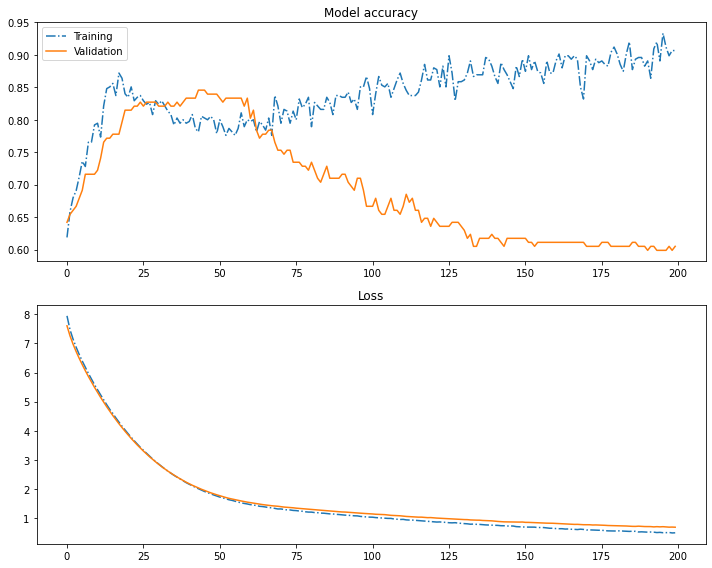

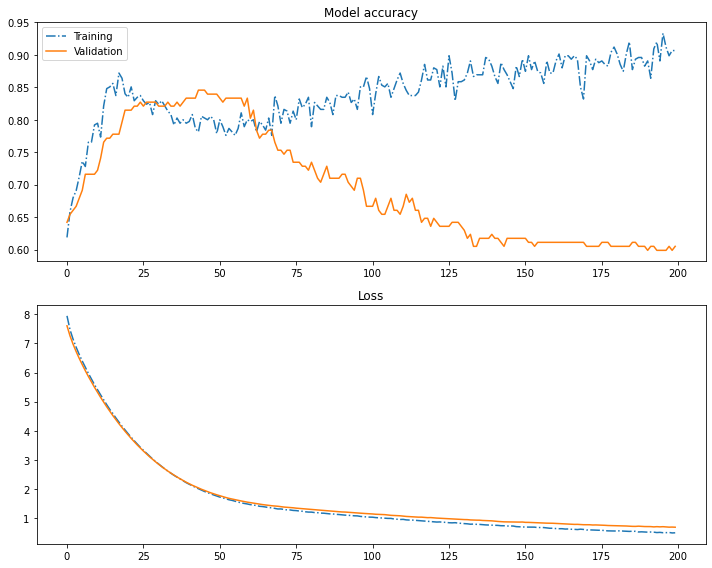

In [237]:
make_binary_acc_loss_plot(history_lstm)

The validation accuracy decreases after 60 epochs. Recall our bubble region graph. For the validation data region(after 70% of the dataset), there is not enough true bubble dummy values. Therefore, it would be plausible to interpret the above results as follows. Before 60 epochs, the model predicts well because it only predicts false (no bubble). After 60 epochs, the true dummy(bubble) starts to show up and it leads to decreasing validation accuracy. As a result, the LSTM model is worse than the simple RNN model since it has lower accuracy and higher loss. 

According to above LSTM model, it demonstrates prediction as follows.

In [108]:
# demonstrate prediction
X_input_hpi=X[-1]
X_input_hpi= X_input_hpi.reshape((1, X.shape[1], X.shape[2]))
yhat_lstm = model_lstm.predict(X_input_hpi)
print(yhat_lstm)

[[0.69037485 0.68770707 0.62918806]]


In [239]:
# compare the two models.
print(yhat_lstm)
print(yhat_rnn)

[[0.69037485 0.68770707 0.62918806]]
[[0.6311022  0.6223203  0.64255494]]


The prediction results look similar. However, since the simple RNN model has higher accuray and lower loss function, the prefiction from simple RNN model is more reliable.  
Next, I will apply cross validation to improve the LSTM model.

## Cross Validation for choosing hyperparameters

For cross-validation, I will use the GridSearchCV method. Since we have four unknown hyperparameters, the GridSearchCV method will help us find the best combination of the four hyperparameres.   
The code is as follows.

In [240]:
from sklearn.model_selection import GridSearchCV  

In [111]:
def model_LSTM_hpi(kernel_regularizer, recurrent_regularizer ,bias_regularizer, dropout):
    lstm = keras.Sequential()
    lstm.add(tf.keras.layers.LSTM(15,activation="tanh", kernel_regularizer=kernel_regularizer,
                                            recurrent_regularizer=recurrent_regularizer,
                                            bias_regularizer=bias_regularizer,
                                            dropout=dropout,
                                            input_shape=(X.shape[1],X.shape[2]), 
                                            return_sequences=False ))
    lstm.add(Dense(y.shape[1],activation="sigmoid"))

    lstm.compile(optimizer="RMSProp",loss="binary_crossentropy", metrics='accuracy')  #use accuracy to avoid warnings
    
    return lstm

In [112]:
model_grid_hpi = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn= model_LSTM_hpi,
                                                            verbose= 0)

/var/folders/mc/mbs2vjqs7dzfpxw7nnj54t440000gn/T/ipykernel_1134/1978753971.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_grid_hpi = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn= model_LSTM_hpi,


In [113]:
# building hyparparameter grid.
alpha , beta , gamma  = np.arange(0,0.5,0.1) , np.arange(0,0.5,0.1), np.arange(0,0.5,0.1)
a , b , c =[],[],[]

for i in beta :
    a.append(regularizers.l2(i)) 

for i in beta :
    b.append(regularizers.l2(i)) 

for i in gamma :
    c.append(regularizers.l2(i))     
    

In [114]:
delta= np.arange(0,0.5,0.1)

param_grid_hpi = dict( kernel_regularizer=a,
                    recurrent_regularizer=b,
                    bias_regularizer=c,
                    dropout=delta)

grid_hpi = GridSearchCV(estimator=model_grid_hpi,
                    param_grid=param_grid_hpi,
                    cv=3,
                    verbose=0)

In [246]:
grid_result_hpi = grid_hpi.fit(X,y)

In [248]:
print("Best accuracy : {}\n Best combination: {}".format(grid_result_hpi.best_score_,grid_result_hpi.best_params_))
# Drop out = 0.3

Best accuracy : 0.7261770168940226
 Best combination: {'bias_regularizer': <keras.regularizers.L2 object at 0x7f9cd83b4730>, 'dropout': 0.30000000000000004, 'kernel_regularizer': <keras.regularizers.L2 object at 0x7f9cd83b4250>, 'recurrent_regularizer': <keras.regularizers.L2 object at 0x7f9cd83b4be0>}


In [249]:
# The best kernel_regularizer
print(a)
print(alpha) 

# The best one is 0.4

[<keras.regularizers.L2 object at 0x7f9cd767e6a0>, <keras.regularizers.L2 object at 0x7f9cd83b4df0>, <keras.regularizers.L2 object at 0x7f9cd83b48b0>, <keras.regularizers.L2 object at 0x7f9cd83b4a30>, <keras.regularizers.L2 object at 0x7f9cd83b4250>]
[0.  0.1 0.2 0.3 0.4]


In [191]:
# Best recurrent_regularizer
print(b)
print(beta) 

# best one is 0.1

[<keras.regularizers.L2 object at 0x7f9cd767ed60>, <keras.regularizers.L2 object at 0x7f9cd83b4be0>, <keras.regularizers.L2 object at 0x7f9cd83b4af0>, <keras.regularizers.L2 object at 0x7f9cd83b4ca0>, <keras.regularizers.L2 object at 0x7f9cd83b4520>]
[0.  0.1 0.2 0.3 0.4]


In [192]:
# Best bias_regularizer
print(c)
print(gamma) 

# best one is 0

[<keras.regularizers.L2 object at 0x7f9cd83b4730>, <keras.regularizers.L2 object at 0x7f9cd83b4fa0>, <keras.regularizers.L2 object at 0x7f9cd83b4790>, <keras.regularizers.L2 object at 0x7f9cd83b4280>, <keras.regularizers.L2 object at 0x7f9cd83b4400>]
[0.  0.1 0.2 0.3 0.4]


The GridSearchCV results are as follows. For kernel regularizer, I will use regularizers.l2(0.4). For recurrent_regularizer, I will use regularizers.l2(0.1). For bias_regularizer, I will use regularizers.l2(0), and for dropout, I will use 0.3.  

LSTM model with above hyperparameters is as follows.

In [42]:

model_lstm_cv = keras.Sequential()
model_lstm_cv.add(tf.keras.layers.LSTM(15, kernel_regularizer=regularizers.l2(0.4),
                                        recurrent_regularizer=regularizers.l2(0.1),
                                        bias_regularizer=regularizers.l2(0),
                                        dropout=0.3,
                                        input_shape=(X.shape[1],X.shape[2]), 
                                        return_sequences=False))
model_lstm_cv.add(Dense(y.shape[1],activation="sigmoid"))

model_lstm_cv.compile(optimizer="RMSProp",loss="binary_crossentropy", metrics=[keras.metrics.binary_accuracy]) 

model_lstm_cv.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 15)                1500      
                                                                 
 dense_5 (Dense)             (None, 3)                 48        
                                                                 
Total params: 1,548
Trainable params: 1,548
Non-trainable params: 0
_________________________________________________________________


In [43]:
history_lstm_cv = model_lstm_cv.fit(
    X_train, y_train,
    epochs=200,
    validation_data=(X_test,y_test)
)

train_loss_keras_cv, train_acc_keras_cv = model_lstm_cv.evaluate(X_train, y_train)
test_loss_keras_cv, test_acc_keras_cv = model_lstm_cv.evaluate(X_test, y_test)


Epoch 1/200
4/4 [==============================] - 2s 121ms/step - loss: 7.9856 - binary_accuracy: 0.5227 - val_loss: 7.5351 - val_binary_accuracy: 0.6543
Epoch 2/200
4/4 [==============================] - 0s 9ms/step - loss: 7.4266 - binary_accuracy: 0.5547 - val_loss: 7.1274 - val_binary_accuracy: 0.6543
Epoch 3/200
4/4 [==============================] - 0s 9ms/step - loss: 7.0460 - binary_accuracy: 0.5547 - val_loss: 6.7948 - val_binary_accuracy: 0.6728
Epoch 4/200
4/4 [==============================] - 0s 10ms/step - loss: 6.7286 - binary_accuracy: 0.5760 - val_loss: 6.5011 - val_binary_accuracy: 0.6728
Epoch 5/200
4/4 [==============================] - 0s 10ms/step - loss: 6.4368 - binary_accuracy: 0.5813 - val_loss: 6.2309 - val_binary_accuracy: 0.6728
Epoch 6/200
4/4 [==============================] - 0s 10ms/step - loss: 6.1688 - binary_accuracy: 0.6000 - val_loss: 5.9774 - val_binary_accuracy: 0.6852
Epoch 7/200
4/4 [==============================] - 0s 10ms/step - loss: 5.920

4/4 [==============================] - 0s 9ms/step - loss: 0.7583 - binary_accuracy: 0.7120 - val_loss: 0.7097 - val_binary_accuracy: 0.9259
Epoch 55/200
4/4 [==============================] - 0s 9ms/step - loss: 0.7346 - binary_accuracy: 0.7120 - val_loss: 0.6809 - val_binary_accuracy: 0.9259
Epoch 56/200
4/4 [==============================] - 0s 8ms/step - loss: 0.7121 - binary_accuracy: 0.7120 - val_loss: 0.6599 - val_binary_accuracy: 0.9259
Epoch 57/200
4/4 [==============================] - 0s 8ms/step - loss: 0.6889 - binary_accuracy: 0.7173 - val_loss: 0.6400 - val_binary_accuracy: 0.9259
Epoch 58/200
4/4 [==============================] - 0s 8ms/step - loss: 0.6707 - binary_accuracy: 0.7120 - val_loss: 0.6219 - val_binary_accuracy: 0.9259
Epoch 59/200
4/4 [==============================] - 0s 8ms/step - loss: 0.6500 - binary_accuracy: 0.7120 - val_loss: 0.6071 - val_binary_accuracy: 0.9259
Epoch 60/200
4/4 [==============================] - 0s 8ms/step - loss: 0.6377 - binary_a

4/4 [==============================] - 0s 8ms/step - loss: 0.4565 - binary_accuracy: 0.8160 - val_loss: 0.5419 - val_binary_accuracy: 0.7284
Epoch 108/200
4/4 [==============================] - 0s 8ms/step - loss: 0.4444 - binary_accuracy: 0.8560 - val_loss: 0.5445 - val_binary_accuracy: 0.7222
Epoch 109/200
4/4 [==============================] - 0s 8ms/step - loss: 0.4590 - binary_accuracy: 0.8347 - val_loss: 0.5398 - val_binary_accuracy: 0.7284
Epoch 110/200
4/4 [==============================] - 0s 8ms/step - loss: 0.4438 - binary_accuracy: 0.8453 - val_loss: 0.5414 - val_binary_accuracy: 0.7284
Epoch 111/200
4/4 [==============================] - 0s 8ms/step - loss: 0.4445 - binary_accuracy: 0.8373 - val_loss: 0.5442 - val_binary_accuracy: 0.7160
Epoch 112/200
4/4 [==============================] - 0s 8ms/step - loss: 0.4445 - binary_accuracy: 0.8373 - val_loss: 0.5440 - val_binary_accuracy: 0.6852
Epoch 113/200
4/4 [==============================] - 0s 8ms/step - loss: 0.4353 - bi

Epoch 160/200
4/4 [==============================] - 0s 8ms/step - loss: 0.3677 - binary_accuracy: 0.9067 - val_loss: 0.6916 - val_binary_accuracy: 0.5926
Epoch 161/200
4/4 [==============================] - 0s 8ms/step - loss: 0.3616 - binary_accuracy: 0.9147 - val_loss: 0.6830 - val_binary_accuracy: 0.5926
Epoch 162/200
4/4 [==============================] - 0s 8ms/step - loss: 0.3624 - binary_accuracy: 0.8987 - val_loss: 0.6946 - val_binary_accuracy: 0.5926
Epoch 163/200
4/4 [==============================] - 0s 8ms/step - loss: 0.3594 - binary_accuracy: 0.8960 - val_loss: 0.6993 - val_binary_accuracy: 0.5926
Epoch 164/200
4/4 [==============================] - 0s 8ms/step - loss: 0.3574 - binary_accuracy: 0.8960 - val_loss: 0.6929 - val_binary_accuracy: 0.5926
Epoch 165/200
4/4 [==============================] - 0s 8ms/step - loss: 0.3561 - binary_accuracy: 0.9307 - val_loss: 0.7070 - val_binary_accuracy: 0.5926
Epoch 166/200
4/4 [==============================] - 0s 8ms/step - los

In [44]:
print('Test accuracy using keras:', test_acc_keras_cv)
print('Train accuracy using keras:', train_acc_keras_cv)

print('Test loss using keras:', test_loss_keras_cv)
print('Train loss using keras:', train_loss_keras_cv)

Test accuracy using keras: 0.5740740895271301
Train accuracy using keras: 0.9440000057220459
Test loss using keras: 0.8798340559005737
Train loss using keras: 0.297187864780426


The result above shows that it has 57% test accuracy and 88% test loss. Ironically, this result is worse than pervious LSTM model. It has the lowest test accuracy and highest test loss level.

[[0.8803241  0.82594115 0.8288745 ]]


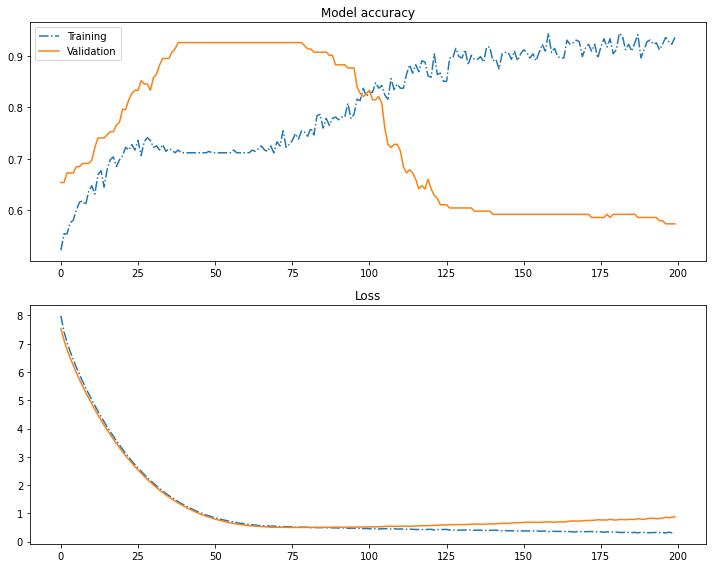

In [47]:
make_binary_acc_loss_plot(history_lstm_cv)

# demonstrate prediction
X_input_hpi=X[-1]
X_input_hpi= X_input_hpi.reshape((1, X.shape[1], X.shape[2]))
yhat_lstm_cv = model_lstm_cv.predict(X_input_hpi)
print(yhat_lstm_cv)

After 90 epochs, it starts to overfitting.

According to this model, the prediction results implies that the probability of an existing bubble next three months is 88.03%, the next six months is 82.59% and the next nine months is 82.88%  

This result corresponds with the previous LSTM explanation. The model accuracy decreases after 75 epochs. Recall our bubble period graph. For the validation data region, there is not enough bubble period data. Therefore, it would be plausible to interpret the above results as follows. Before 75 epochs, the models predict well because they predict false (no bubble). After 75 epochs, the true dummy(bubble) starts to show up and it leads to decreasing validation accuracy. This result is not convincing results. Therefore, in the next section, I will instead use the housing bubble detections using the rent index as a proxy target variable. 

---

## 4. Housing bubble detection using Rent Index

&ensp;To measure the rent, I use the rent index constructed by [Bureau of Labor Statistics](https://fred.stlouisfed.org/series/CUUR0000SEHA). The rent index is proxied by the rent of the primary residence, which is a component of the consumer price index (all urban consumers). The data is also in quarterly frequency based on 1982-84:100.  

I use same method as the housing bubble detection using House Price Index. I apply the psymonitor” package using rent index.  

The result is as follows.  

Details are in the R code.


In [49]:
bubble_rent = pd.read_csv('/Users/choejunhoe/Desktop/Housingbubbleproject/MLProject/code_anddata/rent_bubble.csv')
bubble_rent = bubble_rent.iloc[: , 1:]

I add a new column for the housing bubble dummy variable captured by the rent index.

In [50]:
indicator['bubble_rent']=np.array(bubble_rent["bubble_rent"])
indicator

,hpi,rent,permits,M2,GDP,PPI,Inflation,unempolyment,Federal Fund Rate,bubble,bubble_rent
DATE,,,,,,,,,,,
1976-01-01,0.010283,0.014664,1183.000000,0.030482,0.022488,0.004469,0.063412,7.733333,4.826484,0,0
1976-04-01,0.040872,0.012785,1171.333333,0.034660,0.007337,0.015573,0.060150,7.566667,5.195385,0,0
1976-07-01,0.016196,0.013172,1345.000000,0.024643,0.005487,0.012048,0.055897,7.733333,5.283478,0,0
1976-10-01,0.011126,0.013001,1489.000000,0.035271,0.007249,0.008658,0.051870,7.766667,4.874239,0,0
1977-01-01,0.033160,0.017647,1562.000000,0.031960,0.011815,0.021459,0.059034,7.500000,4.660667,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01,0.021964,0.004677,1670.333333,0.032704,0.011153,0.021448,0.012001,6.766667,0.088804,0,0
2021-01-01,0.023541,0.003496,1786.333333,0.033814,0.015339,0.058962,0.018973,6.200000,0.076889,0,0
2021-04-01,0.055146,0.005213,1705.666667,0.037142,0.016407,0.065514,0.048132,5.900000,0.068242,0,0


In [51]:
indicator.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hpi,184.0,0.012079,0.013517,-0.031513,0.007471,0.012206,0.017638,0.055806
rent,184.0,0.009794,0.004794,-0.000420,0.006749,0.008732,0.012311,0.026234
permits,184.0,1377.666667,380.290895,538.666667,1114.750000,1398.000000,1670.583333,2228.333333
M2,184.0,0.016817,0.012384,-0.005693,0.010134,0.015568,0.021527,0.131024
GDP,184.0,0.006798,0.011474,-0.089373,0.003601,0.007293,0.010707,0.075475
PPI,184.0,0.007823,0.019519,-0.111906,-0.000377,0.007374,0.016982,0.065990
Inflation,184.0,0.036111,0.027469,-0.016070,0.018956,0.029115,0.043074,0.144258
unempolyment,184.0,6.262862,1.697826,3.600000,5.000000,5.883333,7.341667,12.966667
Federal Fund Rate,184.0,4.716309,4.030789,0.058791,1.119484,4.822481,6.779558,17.786923
bubble,184.0,0.217391,0.413596,0.000000,0.000000,0.000000,0.000000,1.000000


The summary statistics show that the new target variable has more true dummy values than the previous target variable. This implies that the new target variable has more complicated patterns for a simple RNN and LSTM to learn.

Now, I will draw graphs for inputs that include the housing bubble period as shaded regions.

In [233]:
bubble_rent_dummy= indicator.iloc[:,-1].squeeze()
bubble_rent_dummy


DATE
1976-01-01    0
1976-04-01    0
1976-07-01    0
1976-10-01    0
1977-01-01    0
             ..
2020-10-01    0
2021-01-01    0
2021-04-01    0
2021-07-01    0
2021-10-01    1
Freq: QS-JAN, Name: bubble_rent, Length: 184, dtype: int64

In [234]:
def get_bubble_rent_data(): 
 # extract start and end date for each bubble period
    start_dates_rent = bubble_rent_dummy.loc[bubble_rent_dummy.diff() > 0].index.tolist()
    if bubble_rent_dummy.iloc[0] > 0:
        start_dates_rent = [bubble_rent_dummy.index[0]] + start_dates_rent

    end_dates_rent = bubble_rent_dummy.loc[bubble_rent_dummy.diff() < 0].index.tolist()

    if (len(start_dates_rent) != len(end_dates_rent)) and (len(start_dates_rent) != len(end_dates_rent) + 1):
        raise ValueError("Need to have same number of start/end dates!")

    return start_dates_rent, end_dates_rent

start_dates_rent, end_dates_rent = get_bubble_rent_data()

print(start_dates_rent)
print(end_dates_rent)


[Timestamp('1982-04-01 00:00:00'), Timestamp('1985-07-01 00:00:00'), Timestamp('1997-10-01 00:00:00'), Timestamp('2014-01-01 00:00:00'), Timestamp('2015-07-01 00:00:00'), Timestamp('2021-10-01 00:00:00')]
[Timestamp('1983-10-01 00:00:00'), Timestamp('1987-01-01 00:00:00'), Timestamp('2009-07-01 00:00:00'), Timestamp('2015-04-01 00:00:00'), Timestamp('2020-07-01 00:00:00')]


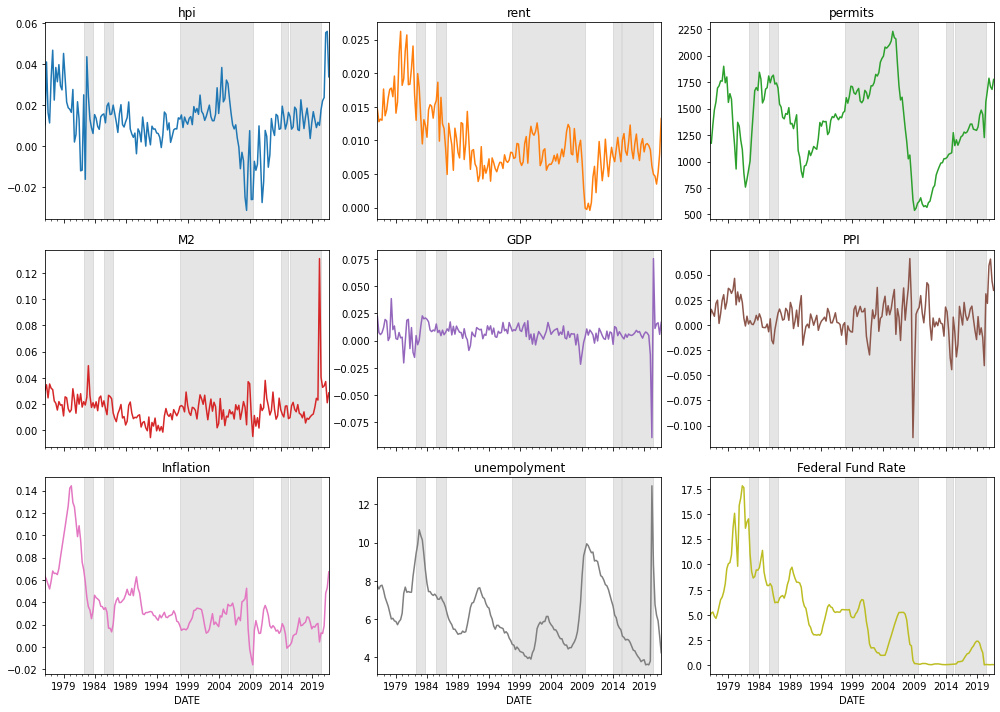

In [235]:
indicator_rent_plot= indicator.iloc[: , :-2]

def add_bubble_rent_bands(ax):
    for s, e in zip(start_dates_rent, end_dates_rent):
        ax.axvspan(s, e, color="grey", alpha=0.2)

axs = indicator_rent_plot.plot(subplots=True, figsize=(14, 10), layout=(3, 3), legend=False)

for i, ax in enumerate(axs.flatten()):
    add_bubble_rent_bands(ax)
    ax.set_title(list(indicator_rent_plot)[i])

fig = axs[0, 0].get_figure()
fig.tight_layout();


The shaded areas above are the periods when the bubble has been detected. Compare to previous bubble region plots, we now have more true dummy values in our target variable.

#### Data Preprocessing

Since we are using simple RNN and LSTM model, first, we should normalize our input data and, second, we also should convert the time series dataset to a supervised learning problem. For this project, I am conducting multivariate and multi-step forecasting as well.

In [166]:
#normalizing inputs
rent_features= indicator.loc[:,'hpi':"Federal Fund Rate"]
scaler_rent = StandardScaler()
scaler_rent = scaler_rent.fit(rent_features)
rent_bubble_scaled = scaler_rent.transform(rent_features)

In [167]:
rent_bubble_scaled = pd.DataFrame(rent_bubble_scaled, columns=['hpi','rent','permits','M2','GDP','PPI','Inf','unemp','FFR'])
rent_bubble_scaled['bubble']=bubble_rent['bubble_rent']

### Multivariate and Multi-step Forecasting

This method is same as the House Price Index case.  

I frame the supervised learning problem as predicting the bubble next three month, six months, and nine months given the input variables at the window width of 4. This implies the model uses four time steps for each input time series as input and predicts the next three time steps of the output sequence beyond the dataset.  

The code is as follows.

In [168]:
X_rent , y_rent = split_sequences(np.array(rent_bubble_scaled),4,3)

In [169]:
for i in range(len(X_rent)):
  print(X_rent[i], y_rent[i])


[[-0.51328554 -0.13324633  1.01873328  1.10643844  1.37118826 -0.17227842
   0.99655337  0.86845347  0.02740777]
 [-0.54404752  2.13583934  0.62556809  1.44476127  0.04713772  0.39812949
   0.87750925  0.7700209   0.11917831]
 [-0.08613353  0.30536735  0.70661752  0.63364961 -0.11453414  0.21706208
   0.72223881  0.86845347  0.14109313]
 [ 0.29355714 -0.07068475  0.670794    1.49424424  0.03940382  0.04290321
   0.57523595  0.88813998  0.0392878 ]] [0. 0. 0.]
[[-0.54404752  2.13583934  0.62556809  1.44476127  0.04713772  0.39812949
   0.87750925  0.7700209   0.11917831]
 [-0.08613353  0.30536735  0.70661752  0.63364961 -0.11453414  0.21706208
   0.72223881  0.86845347  0.14109313]
 [ 0.29355714 -0.07068475  0.670794    1.49424424  0.03940382  0.04290321
   0.57523595  0.88813998  0.0392878 ]
 [ 0.48603922  1.5637856   1.64265169  1.22616373  0.43846712  0.70052113
   0.83675716  0.73064787 -0.01384205]] [0. 0. 0.]
[[-0.08613353  0.30536735  0.70661752  0.63364961 -0.11453414  0.2170620

In [88]:
training_size = int(len(X_rent) * 0.7)
X_rent_train, y_rent_train = X_rent[:training_size], y_rent[:training_size]
X_rent_test, y_rent_test = X_rent[training_size:], y_rent[training_size:]


## Model Description

I will use simple RNN model and LSTM model to predict next three time steps. 

### Simple RNN model
For simple RNN model, I used relu activation function with 0.25 dropout and 0.3 kernel regularizer l2. I use RMSProp optimizer, binary crossestropy loss function, and binary accuracy metrics. Moreover, I used 10 neurons for RNN layer, and sigmoid activation function for the last layer. I use 200 epochs to check underfitting and overfitting. 

In [89]:
model_rent = keras.Sequential()
model_rent.add(tf.keras.layers.SimpleRNN(10, activation="tanh",
                                            kernel_regularizer=regularizers.l2(0.3),
                                            input_shape=(X_rent.shape[1],X_rent.shape[2]) ,return_sequences=False))
model_rent.add(Dropout(0.25))

model_rent.add(Dense(y_rent.shape[1],activation="sigmoid"))

model_rent.compile(optimizer="RMSprop",loss="binary_crossentropy", metrics=[keras.metrics.binary_accuracy]) 

model_rent.summary()


Model: "sequential_1885"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 10)                200       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_3770 (Dense)          (None, 3)                 33        
                                                                 
Total params: 233
Trainable params: 233
Non-trainable params: 0
_________________________________________________________________


In [90]:
history_rent = model_rent.fit(
    X_rent_train, y_rent_train,
    epochs=200,
    validation_data=(X_rent_test,y_rent_test)
)

train_loss_keras_rent, train_acc_keras_rent = model_rent.evaluate(X_rent_train, y_rent_train)
test_loss_keras_rent, test_acc_keras_rent = model_rent.evaluate(X_rent_test, y_rent_test)




Epoch 1/200
4/4 [==============================] - 1s 60ms/step - loss: 3.3029 - binary_accuracy: 0.5253 - val_loss: 3.2455 - val_binary_accuracy: 0.5185
Epoch 2/200
4/4 [==============================] - 0s 7ms/step - loss: 3.2262 - binary_accuracy: 0.4720 - val_loss: 3.1605 - val_binary_accuracy: 0.5185
Epoch 3/200
4/4 [==============================] - 0s 8ms/step - loss: 3.1209 - binary_accuracy: 0.5280 - val_loss: 3.0906 - val_binary_accuracy: 0.5185
Epoch 4/200
4/4 [==============================] - 0s 10ms/step - loss: 3.0542 - binary_accuracy: 0.5440 - val_loss: 3.0258 - val_binary_accuracy: 0.5247
Epoch 5/200
4/4 [==============================] - 0s 9ms/step - loss: 2.9900 - binary_accuracy: 0.5547 - val_loss: 2.9663 - val_binary_accuracy: 0.5247
Epoch 6/200
4/4 [==============================] - 0s 11ms/step - loss: 2.9156 - binary_accuracy: 0.5680 - val_loss: 2.9098 - val_binary_accuracy: 0.5247
Epoch 7/200
4/4 [==============================] - 0s 10ms/step - loss: 2.8808 

In [91]:
print('Test accuracy using keras:', test_acc_keras_rent)
print('Train accuracy using keras:', train_acc_keras_rent)

print('Test loss using keras:', test_loss_keras_rent)
print('Train loss using keras:', train_loss_keras_rent)

Test accuracy using keras: 0.7407407164573669
Train accuracy using keras: 0.8960000276565552
Test loss using keras: 0.7676490545272827
Train loss using keras: 0.2716580331325531


The result above shows that it has 74% test accuracy and 76% test loss. It has very high test loss.  
Next, I check overfitting by drawing history accuracy and loss values. It is shown below.

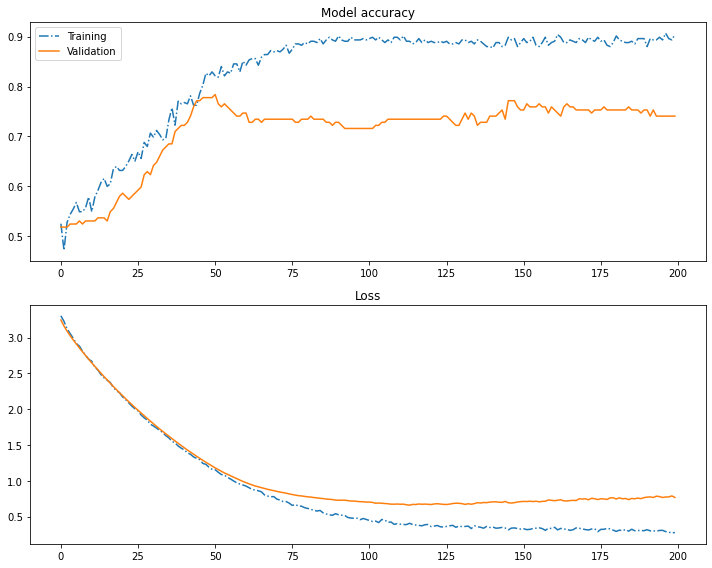

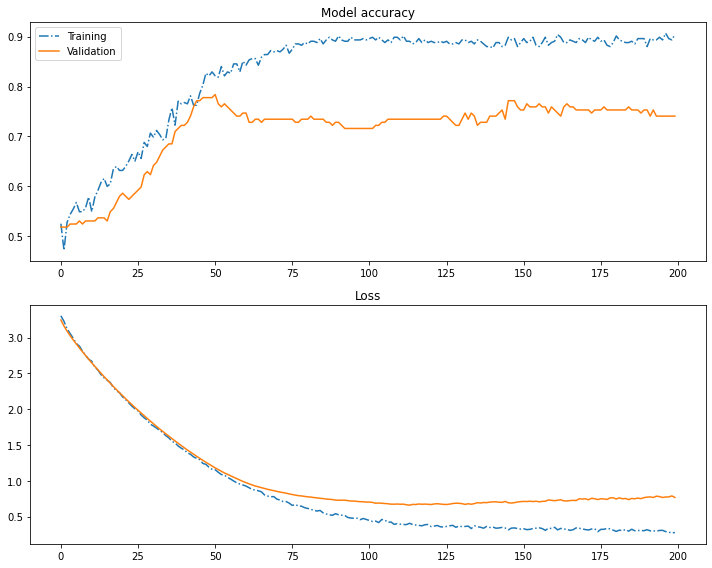

In [92]:
make_binary_acc_loss_plot(history_rent)

The simple RNN model is overfiiting after 75 epochs. This is why the model has very high test loss. To prevent it, we should use higher regularizers or different model.  

For this project, instead of adding new regularizers, I will use LSTM model.

In [93]:
# demonstrate prediction
X_input_rent=X_rent[-1]
X_input_rent= X_input_rent.reshape((1, X_rent.shape[1], X_rent.shape[2]))
yhat_rent_rnn = model_rent.predict(X_input_rent)
print(yhat_rent_rnn)

[[0.02931368 0.02441081 0.03512955]]


The above results imply that, according to the simple RNN model, the probability of an existing bubble next three months is 2.93%, the next six months is 2.44% and the next nine months is 3.51%. Since the model is overfitting, the results are not reliable enough.  

Now, I will use LSTM model and compare the results.

### LSTM

For the LSTM model, I use tanh activation function with three regularizers and one dropout. Since we do not have a large dataset, the multivariate and multi-step LSTM model may go overfitting. The regularizers and a dropout will prevent overfitting. Before conducting cross-validation, I arbitrarily choose the hyperparametes. 
Moreover, I use RMSProp optimizer, binary cross-entropy loss function, and binary accuracy metrics. I used 20 neurons for LSTM layer with tanh activation function, 5 neurons for hidden dense layer with relu activation function and sigmoid activation function for the last layer. I use 200 epochs to check underfitting and overfitting. 



In [94]:

model_lstm_rent = keras.Sequential()
model_lstm_rent.add(tf.keras.layers.LSTM(20, activation="tanh",kernel_regularizer=regularizers.l2(0.3),
                                        recurrent_regularizer=regularizers.l2(0.05),
                                        bias_regularizer=regularizers.l2(0.05),
                                        dropout=0.25,
                                        input_shape=(X_rent.shape[1],X_rent.shape[2]), 
                                        return_sequences=False))
               

model_lstm_rent.add(Dense(5,activation="relu"))

model_lstm_rent.add(Dense(y_rent.shape[1],activation="sigmoid"))

model_lstm_rent.compile(optimizer="RMSProp",loss="binary_crossentropy", metrics=[keras.metrics.binary_accuracy]) 

model_lstm_rent.summary()


Model: "sequential_1886"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1883 (LSTM)            (None, 20)                2400      
                                                                 
 dense_3771 (Dense)          (None, 5)                 105       
                                                                 
 dense_3772 (Dense)          (None, 3)                 18        
                                                                 
Total params: 2,523
Trainable params: 2,523
Non-trainable params: 0
_________________________________________________________________


In [95]:
history_lstm_rent = model_lstm_rent.fit(
    X_rent_train, y_rent_train,
    epochs=200,
    validation_data=(X_rent_test,y_rent_test)
)

train_loss_keras_rent_lstm, train_acc_keras_rent_lstm = model_lstm_rent.evaluate(X_rent_train, y_rent_train)
test_loss_keras_rent_lstm, test_acc_keras_rent_lstm = model_lstm_rent.evaluate(X_rent_test, y_rent_test)

Epoch 1/200
4/4 [==============================] - 2s 119ms/step - loss: 7.3582 - binary_accuracy: 0.5493 - val_loss: 7.0397 - val_binary_accuracy: 0.3519
Epoch 2/200
4/4 [==============================] - 0s 9ms/step - loss: 6.8599 - binary_accuracy: 0.5387 - val_loss: 6.6726 - val_binary_accuracy: 0.3765
Epoch 3/200
4/4 [==============================] - 0s 10ms/step - loss: 6.5253 - binary_accuracy: 0.5440 - val_loss: 6.3735 - val_binary_accuracy: 0.3827
Epoch 4/200
4/4 [==============================] - 0s 12ms/step - loss: 6.2383 - binary_accuracy: 0.5653 - val_loss: 6.1105 - val_binary_accuracy: 0.3827
Epoch 5/200
4/4 [==============================] - 0s 11ms/step - loss: 5.9814 - binary_accuracy: 0.5947 - val_loss: 5.8692 - val_binary_accuracy: 0.3889
Epoch 6/200
4/4 [==============================] - 0s 13ms/step - loss: 5.7499 - binary_accuracy: 0.5680 - val_loss: 5.6427 - val_binary_accuracy: 0.4012
Epoch 7/200
4/4 [==============================] - 0s 11ms/step - loss: 5.52

In [96]:
print('Test accuracy using keras:', test_acc_keras_rent_lstm)
print('Train accuracy using keras:', train_acc_keras_rent_lstm)

print('Test loss using keras:', test_loss_keras_rent_lstm)
print('Train loss using keras:', train_loss_keras_rent_lstm)

Test accuracy using keras: 0.7654321193695068
Train accuracy using keras: 0.9200000166893005
Test loss using keras: 0.6414732933044434
Train loss using keras: 0.4463862478733063


The result above shows that our LSTM model works better than previous simple RNN model. It has 76% test accuracy and 64% test loss. Now, I check overfitting by drawing history accuracy and loss values. It is shown below.

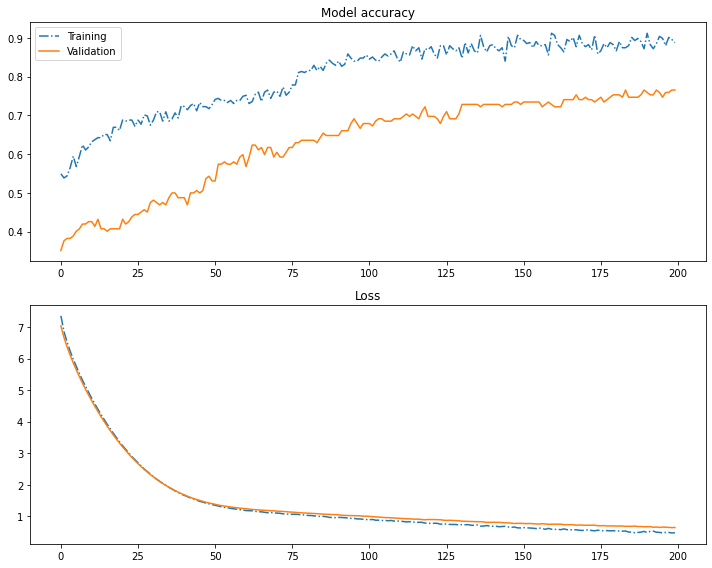

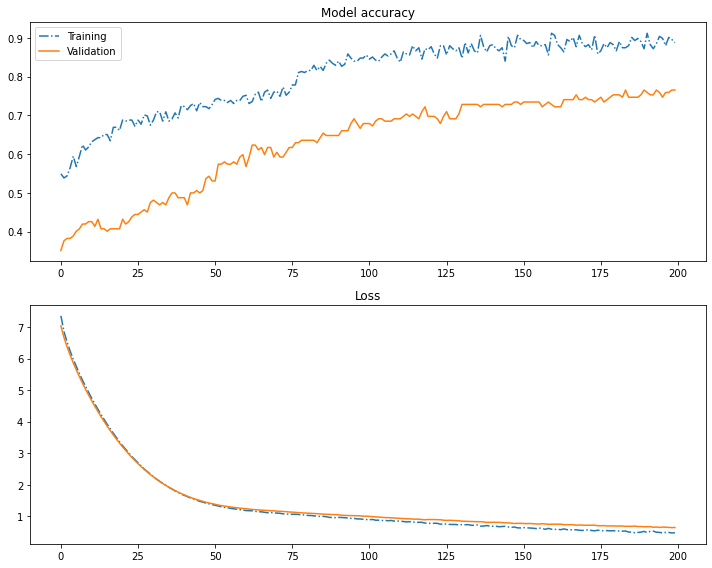

In [97]:
make_binary_acc_loss_plot(history_lstm_rent)

The graph shows no overfitting. Moreover, the model's accuracy path and loss path look better than the previous simple RNN model. Therefore, we can conclude that the LSTM model works better than the simple RNN model.

In [98]:
# demonstrate prediction
X_input_rent=X_rent[-1]
X_input_rent= X_input_rent.reshape((1, X_rent.shape[1], X_rent.shape[2]))
yhat_rent_lstm = model_lstm_rent.predict(X_input_rent)
print(yhat_rent_lstm)


[[0.4834387 0.4129481 0.4539459]]


The prediction result from our LSTM model is follows. The results implies that, according to the simple RNN model, the probability of an existing bubble next three months is 48.34%, the next six months is 41.39% and the next nine months is 45.39%

Next, I will apply cross validation to improve the LSTM model.

# Cross Validation

For cross-validation, I will use the GridSearchCV method as well. Since we have four unknown hyperparameters, the GridSearchCV method will help us find the best combination of the four hyperparameres.
   
The code is as follows.

In [41]:
def model_LSTM(kernel_regularizer, recurrent_regularizer ,bias_regularizer, dropout):
    lstm = keras.Sequential()
    lstm.add(tf.keras.layers.LSTM(20,activation="tanh", kernel_regularizer=kernel_regularizer,
                                            recurrent_regularizer=recurrent_regularizer,
                                            bias_regularizer=bias_regularizer,
                                            dropout=dropout,
                                            input_shape=(X_rent.shape[1],X_rent.shape[2]), return_sequences=False ))
    
    lstm.add(Dense(5,activation="relu"))

    lstm.add(Dense(y_rent.shape[1],activation="sigmoid"))
    lstm.compile(optimizer="RMSProp",loss="binary_crossentropy", metrics='accuracy') 
    
    return lstm



In [42]:
model_grid = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn= model_LSTM,
                                                            verbose= 0)

/var/folders/mc/mbs2vjqs7dzfpxw7nnj54t440000gn/T/ipykernel_1134/2275387368.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_grid = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn= model_LSTM,


In [43]:
alpha , beta , gamma  = np.arange(0,0.5,0.1) , np.arange(0,0.5,0.1), np.arange(0,0.5,0.1)
a , b , c =[],[],[]

for i in beta :
    a.append(regularizers.l2(i)) 

for i in beta :
    b.append(regularizers.l2(i)) 

for i in gamma :
    c.append(regularizers.l2(i))     
    

In [44]:
delta= np.arange(0,0.5,0.1)

param_grid = dict( kernel_regularizer=a,
                    recurrent_regularizer=b,
                    bias_regularizer=c,
                    dropout=delta)

grid = GridSearchCV(estimator=model_grid,
                    param_grid=param_grid,
                    cv=3,
                    verbose=0)

In [45]:
grid_result = grid.fit(X_rent_train,y_rent_train)

In [47]:
print("Best accuracy : {}\n Best combination: {}".format(grid_result.best_score_,grid_result.best_params_))

Best accuracy : 0.9444444378217062
 Best combination: {'bias_regularizer': <keras.regularizers.L2 object at 0x7f9cd10e8130>, 'dropout': 0.0, 'kernel_regularizer': <keras.regularizers.L2 object at 0x7f9cd10efd90>, 'recurrent_regularizer': <keras.regularizers.L2 object at 0x7f9cd10c9b20>}


In [51]:
# The best kernel_regularizer
print(a)
print(alpha) 

# The best one is 0.2

[<keras.regularizers.L2 object at 0x7f9cd10efd60>, <keras.regularizers.L2 object at 0x7f9cd10ef190>, <keras.regularizers.L2 object at 0x7f9cd10efd90>, <keras.regularizers.L2 object at 0x7f9cd10efc40>, <keras.regularizers.L2 object at 0x7f9cd10eff40>]
[0.  0.1 0.2 0.3 0.4]


In [54]:
# Best recurrent_regularizer
print(b)
print(beta) 

# best one is 0.3

[<keras.regularizers.L2 object at 0x7f9cd10efcd0>, <keras.regularizers.L2 object at 0x7f9cd10c9f70>, <keras.regularizers.L2 object at 0x7f9cd10c9640>, <keras.regularizers.L2 object at 0x7f9cd10c9b20>, <keras.regularizers.L2 object at 0x7f9cd10e80a0>]
[0.  0.1 0.2 0.3 0.4]


In [56]:
# Best bias_regularizer
print(c)
print(gamma) 

# best one is 0.1

[<keras.regularizers.L2 object at 0x7f9cd10c9dc0>, <keras.regularizers.L2 object at 0x7f9cd10e8130>, <keras.regularizers.L2 object at 0x7f9cd10e8190>, <keras.regularizers.L2 object at 0x7f9cd10e81f0>, <keras.regularizers.L2 object at 0x7f9cd10e8280>]
[0.  0.1 0.2 0.3 0.4]


The GridSearchCV results is as follows. For kernel regularizer, I will use regularizers.l2(0.2). For recurrent_regularizer, I will use regularizers.l2(0.3). For bias_regularizer, I will use regularizers.l2(0.1), and for dropout, I will use zero. 

Next, I construct new LSTM model with above hyperparameters. For this model, I use 300 epochs to see more clear pictures regarding overfitting.

In [82]:
model_lstm_rent_cv = keras.Sequential()
model_lstm_rent_cv.add(tf.keras.layers.LSTM(20, activation="tanh",kernel_regularizer=regularizers.l2(0.2),
                                        recurrent_regularizer=regularizers.l2(0.3),
                                        bias_regularizer=regularizers.l2(0.1),
                                        dropout=0.0,
                                        input_shape=(X_rent.shape[1],X_rent.shape[2]), 
                                        return_sequences=False))
               

model_lstm_rent_cv.add(Dense(5,activation="relu"))

model_lstm_rent_cv.add(Dense(y_rent.shape[1],activation="sigmoid"))

model_lstm_rent_cv.compile(optimizer="RMSProp",loss="binary_crossentropy", metrics=[keras.metrics.binary_accuracy]) 

model_lstm_rent_cv.summary()


Model: "sequential_1884"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1882 (LSTM)            (None, 20)                2400      
                                                                 
 dense_3768 (Dense)          (None, 5)                 105       
                                                                 
 dense_3769 (Dense)          (None, 3)                 18        
                                                                 
Total params: 2,523
Trainable params: 2,523
Non-trainable params: 0
_________________________________________________________________


In [83]:
history_lstm_rent_cv = model_lstm_rent_cv.fit(
    X_rent_train, y_rent_train,
    epochs=300,
    validation_data=(X_rent_test,y_rent_test)
)

train_loss_keras_rent_lstm_cv, train_acc_keras_rent_lstm_cv = model_lstm_rent_cv.evaluate(X_rent_train, y_rent_train)
test_loss_keras_rent_lstm_cv, test_acc_keras_rent_lstm_cv = model_lstm_rent_cv.evaluate(X_rent_test, y_rent_test)

Epoch 1/300
4/4 [==============================] - 2s 118ms/step - loss: 11.4282 - binary_accuracy: 0.4507 - val_loss: 10.8126 - val_binary_accuracy: 0.5247
Epoch 2/300
4/4 [==============================] - 0s 9ms/step - loss: 10.5737 - binary_accuracy: 0.4693 - val_loss: 10.1890 - val_binary_accuracy: 0.4815
Epoch 3/300
4/4 [==============================] - 0s 10ms/step - loss: 10.0002 - binary_accuracy: 0.4773 - val_loss: 9.6881 - val_binary_accuracy: 0.4938
Epoch 4/300
4/4 [==============================] - 0s 11ms/step - loss: 9.5227 - binary_accuracy: 0.4800 - val_loss: 9.2500 - val_binary_accuracy: 0.5000
Epoch 5/300
4/4 [==============================] - 0s 12ms/step - loss: 9.0985 - binary_accuracy: 0.4747 - val_loss: 8.8514 - val_binary_accuracy: 0.5062
Epoch 6/300
4/4 [==============================] - 0s 12ms/step - loss: 8.7094 - binary_accuracy: 0.4880 - val_loss: 8.4815 - val_binary_accuracy: 0.5000
Epoch 7/300
4/4 [==============================] - 0s 12ms/step - loss:

In [84]:
print('Test accuracy using keras:', test_acc_keras_rent_lstm_cv)
print('Train accuracy using keras:', train_acc_keras_rent_lstm_cv)

print('Test loss using keras:', test_loss_keras_rent_lstm_cv)
print('Train loss using keras:', train_loss_keras_rent_lstm_cv)

Test accuracy using keras: 0.7716048955917358
Train accuracy using keras: 0.9333333969116211
Test loss using keras: 0.5875558257102966
Train loss using keras: 0.2924157679080963


The LSTM model with cross validation shows 77% test accuracy and 58% test loss. This result is better than the former two models.  

Next, I will check overfitting by graph.

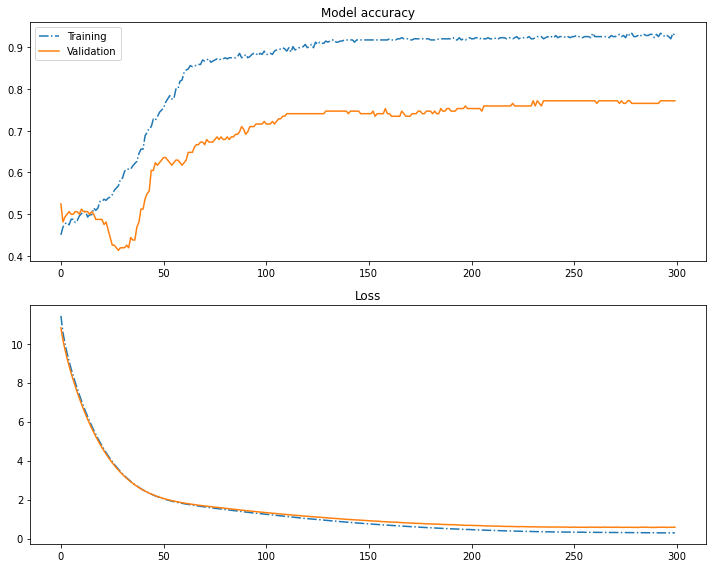

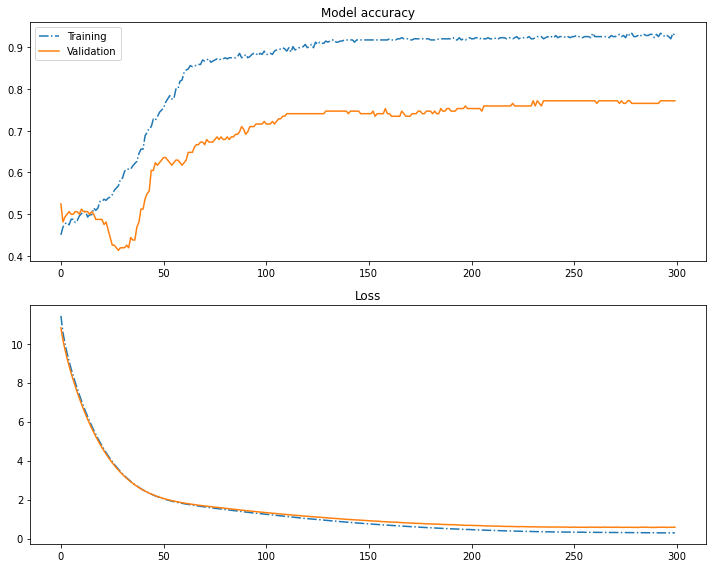

In [85]:
make_binary_acc_loss_plot(history_lstm_rent_cv)

As you can see above, the graph does not show overfitting. Therefore, under the bubble detection using rent index, the LSTM model with Cross Validation shows the most reliable prediction level among them. The predicition results are as follows.

In [86]:
# demonstrate prediction

yhat_rent_lstm_cv = model_lstm_rent_cv.predict(X_input_rent)
print(yhat_rent_lstm_cv)


[[0.2567091  0.13208625 0.22637257]]


According to the model, the results imply that the probability of an existing bubble next three months is 25.67%, the next six months is 13.2% and the next nine months is 22.63%. This result is the most reliable among the rent index models. 

## 5. Conclusion

For this project, I use three models regarding bubble detection with House Price Index and the other three models regarding bubble detection with Rent Index. To summarize, results are as follows.

| HPI             |        Accuracy       | Loss        | 
| --------------- | --------------------- | ----------- | 
| `Simple RNN`    |         0.8086        |    0.2584   |
| `LSTM `         |         0.6049        |    0.6931   |
| `LSTM_CV       `|         0.5740        |    0.8798   | 

| Rent Index (RI) |        Accuracy       | Loss        | 
| --------------- | --------------------- | ----------- | 
| `Simple RNN`    |         0.7407        |    0.7676   |
| `LSTM `         |         0.7654        |    0.6414   |
| `LSTM_CV       `|         0.7716        |    0.5875   | 

Above table shows that the best model is ironically the Simple RNN with HPI bubble detection model. It has the highest accuracy level and the lowest loss level. This is surprising to me since the simplest model shows best results. Since the HPI bubble detection dummy has simple patterns in validation set, the complicate LSTM model is overfitting and the simple model works the best.  

For the models with RI bubble detection model, the LSTM with cross validation shows the best results among the RI models. This is even second best model among six models. This implies since the RI bubble detection dataset has more complicated patterns and less clustered data than the HPI bubble detection dataset, the complicate LSTM model works better than the simple RNN model. This is perfectly line with what we learned. 

The best model's prediction(Simple RNN with HPI) is as follows.


In [255]:
print(yhat_rnn)  

[[0.6311022  0.6223203  0.64255494]]


The result implies that under the simple RNN model with HPI, it is expected to have a bubble in the next three months with a probability of 63.11%, in six months with a probability of 62.22%, and in nine months with a probability of 64.25%. 

Our next task is to increase the validation loss of house price index models. I assume that the bad results came from the bubble dummy data. In this project, we used quarterly housing price index data to detect bubbles. I suggest using the monthly housing price index to detect bubbles or using the housing price to rent ratio to detect bubbles. Moreover, it can be also a good method to extend more inputs. I only considered the basic macro economic dataset. It would be plausible to use more broad micro-macroeconomic datasets such as S&P 500, stock volatility, corporate bond returns, or Eurodollar exchange rates as our new inputs. With a larger dataset, we can use more complicated models which may lead to higher accuracy and low loss.

## 6. References

[1] Fuchs, F., Wahl, M., Zagst, R., & Zheng, X. (2022). Stock Market Crisis Forecasting Using Neural Networks with Input Factor Selection. Applied Sciences, 12(4), 1952.

[2] Hagemann, D., & Wohlmann, M. (2019). An early warning system to identify house price bubbles. Journal of European Real Estate Research.

[3] Park, D., & Ryu, D. (2021). A machine learning-based early warning system for the housing and stock markets. IEEE Access, 9, 85566-85572.

[4] Phillips, P. C., Shi, S., & Yu, J. (2015). Testing for multiple bubbles: Historical episodes of exuberance and collapse in the S&P 500. International economic review, 56(4), 1043-1078.

[5] Phillips, P. C., Shi, S., & Yu, J. (2015). Testing for multiple bubbles: Limit theory of real‐time detectors. International Economic Review, 56(4), 1079-1134.

[6] Wang, P., Zong, L., & Ma, Y. (2020). An integrated early warning system for stock market turbulence. Expert Systems with Applications, 153, 113463.